## Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


No immediately obvious missing values jump out at me, but I will likely need to convert the datetime column to the datetime data type. 

In [3]:
duplicates = df.duplicated()


print("Number of duplicate rows = ", duplicates.sum())

Number of duplicate rows =  0


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])


df.set_index('datetime', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


No explicit duplicates were found. 

## Analysis

A seasonal decomposition of this data will be done after some other analysis. This is an important aspect to consider. 

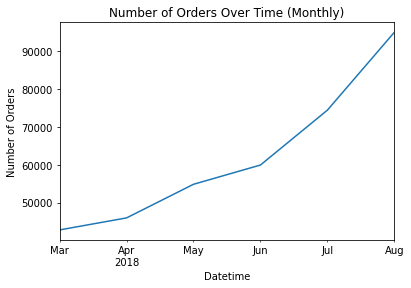

In [5]:

monthly_orders = df['num_orders'].resample('M').sum()


monthly_orders.plot()
plt.title('Number of Orders Over Time (Monthly)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()


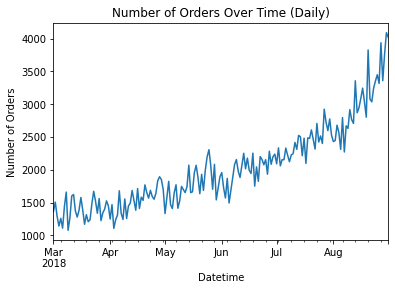

In [6]:

daily_orders = df['num_orders'].resample('D').sum()


daily_orders.plot()
plt.title('Number of Orders Over Time (Daily)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()


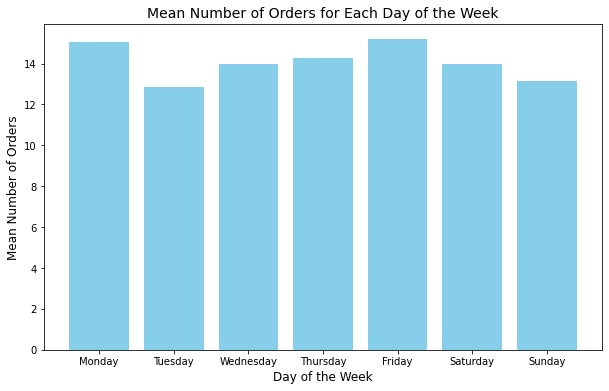

In [7]:

df['day_of_week'] = df.index.dayofweek

mean_orders = df.groupby('day_of_week')['num_orders'].mean()


days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


plt.figure(figsize=(10, 6))
plt.bar(days, mean_orders, color='skyblue')
plt.title('Mean Number of Orders for Each Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Mean Number of Orders', fontsize=12)
plt.show()


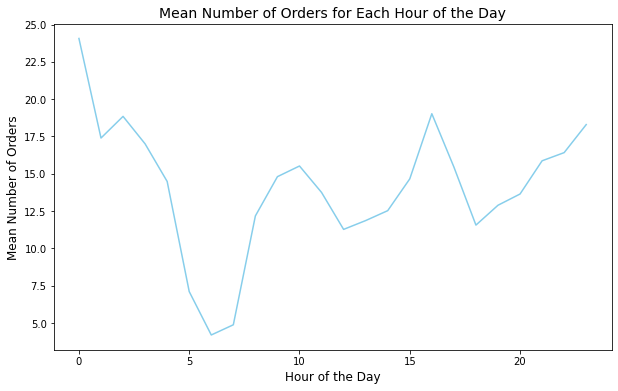

In [8]:

df['hour'] = df.index.hour


mean_orders = df.groupby('hour')['num_orders'].mean()


plt.figure(figsize=(10, 6))
plt.plot(range(24), mean_orders, color='skyblue')
plt.title('Mean Number of Orders for Each Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Mean Number of Orders', fontsize=12)
plt.show()


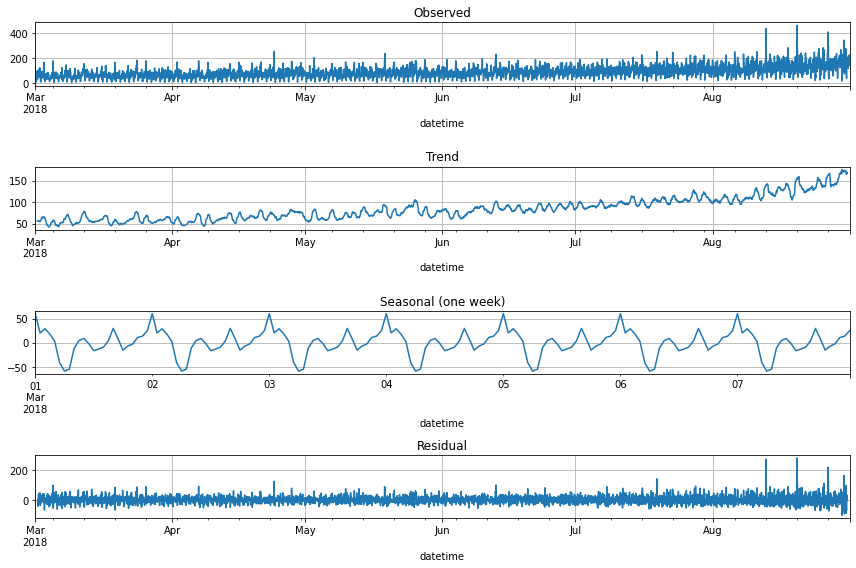

In [9]:

df_resampled = df['num_orders'].resample('1H').sum()


decomposition = seasonal_decompose(df_resampled, model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))


decomposition.seasonal[:24*7].plot(ax=ax3, title='Seasonal (one week)', grid=True)


decomposition.observed.plot(ax=ax1, title='Observed', grid=True)
decomposition.trend.plot(ax=ax2, title='Trend', grid=True)
decomposition.resid.plot(ax=ax4, title='Residual', grid=True)

plt.tight_layout()
plt.show()



Analyzing the data, it can be seen that as March gives way to summer, the number of orders daily really shoots up to peak at the end of August. This is a significant trend which needs to be noted. The day of the week does not seem to play a major part, but monday and friday are the peak days. When looking at the hour of the day, there are some evident peaks at around midnight, 10 am and 4 pm. The start and end of the day have peaks then it could be said. This indicates daily seasonality with a trend upwords throughout the year through the end of august. 

## Training

I will try various machine learning models in order to determine what is most appropriate for this task. A random forest model, a gradient boosting model, an autoregressive moving average model would not be appropriate since the seasonality of this data suggests this may not be a good fit. An autoregressive integrated moving average model, specifically a SARIMA model will be trained, which is a seasonal ARIMA model. 

In [15]:

df = df['2018-03-01 00:00:00':'2018-08-31 23:50:00']


df = df.resample('H').sum()


df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month


for i in range(1, 4):
    df[f'lag_{i}'] = df['num_orders'].shift(i)


df['rolling_mean'] = df['num_orders'].shift().rolling(window=3).mean()
df['rolling_std'] = df['num_orders'].shift().rolling(window=3).std()


df = df.dropna()


X = df.drop('num_orders', axis=1)
y = df['num_orders']


val_start_index = int(len(df) * 0.8)  
test_start_index = int(len(df) * 0.9)  


X_train, y_train = X.iloc[:val_start_index], y.iloc[:val_start_index]
X_val, y_val = X.iloc[val_start_index:test_start_index], y.iloc[val_start_index:test_start_index]
X_test, y_test = X.iloc[test_start_index:], y.iloc[test_start_index:]


display("\nTraining set:\n", X_train.head(), y_train.head())
display("\nValidation set:\n", X_val.head(), y_val.head())
display("\nTest set:\n", X_test.head(), y_test.head())

display("Number of entries in the training set:", len(X_train))
display("Number of entries in the validation set:", len(X_val))
display("Number of entries in the test set:", len(X_test))


'\nTraining set:\n'

,day_of_week,hour,month,lag_1,lag_2,lag_3,rolling_mean,rolling_std
datetime,,,,,,,,
2018-03-01 18:00:00,3,18,3,44.0,43.0,66.0,51.000000,13.000000
2018-03-01 19:00:00,3,19,3,73.0,44.0,43.0,53.333333,17.039171
2018-03-01 20:00:00,3,20,3,45.0,73.0,44.0,54.000000,16.462078
2018-03-01 21:00:00,3,21,3,61.0,45.0,73.0,59.666667,14.047538
2018-03-01 22:00:00,3,22,3,66.0,61.0,45.0,57.333333,10.969655


datetime
2018-03-01 18:00:00     73
2018-03-01 19:00:00     45
2018-03-01 20:00:00     61
2018-03-01 21:00:00     66
2018-03-01 22:00:00    113
Freq: H, Name: num_orders, dtype: int64

'\nValidation set:\n'

,day_of_week,hour,month,lag_1,lag_2,lag_3,rolling_mean,rolling_std
datetime,,,,,,,,
2018-07-26 08:00:00,3,8,7,39.0,21.0,83.0,47.666667,31.895663
2018-07-26 09:00:00,3,9,7,80.0,39.0,21.0,46.666667,30.237945
2018-07-26 10:00:00,3,10,7,138.0,80.0,39.0,85.666667,49.742671
2018-07-26 11:00:00,3,11,7,142.0,138.0,80.0,120.000000,34.698703
2018-07-26 12:00:00,3,12,7,86.0,142.0,138.0,122.000000,31.240999


datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
Freq: H, Name: num_orders, dtype: int64

'\nTest set:\n'

,day_of_week,hour,month,lag_1,lag_2,lag_3,rolling_mean,rolling_std
datetime,,,,,,,,
2018-08-13 16:00:00,0,16,8,175.0,102.0,119.0,132.000000,38.196859
2018-08-13 17:00:00,0,17,8,144.0,175.0,102.0,140.333333,36.637867
2018-08-13 18:00:00,0,18,8,152.0,144.0,175.0,157.000000,16.093477
2018-08-13 19:00:00,0,19,8,104.0,152.0,144.0,133.333333,25.716402
2018-08-13 20:00:00,0,20,8,91.0,104.0,152.0,115.666667,32.129944


datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
Freq: H, Name: num_orders, dtype: int64

'Number of entries in the training set:'

3518

'Number of entries in the validation set:'

440

'Number of entries in the test set:'

440

I resampled by the hour, added significantly more features for the models to learn on (lag features and moving avg + moving std), and split the data into designated time chunks so that no data leakage remained. Additionally, the lag and rolling average/std features should also help combat data leakage from the future influencing the model. Since features are created based on resampling every hour, this should indeed be an adequite train test split. I split the training, testing and validation sets based on the ratio outline in the instructions, with the testing set getting 10 percent and the validation set also getting 10 percent of the entries. The training set, therefore, got 80 percent of the data. 

In [16]:
tscv = TimeSeriesSplit(n_splits=3)


model = RandomForestRegressor()
hyperparameters = {
    'n_estimators': [50, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [2, 5],
    'min_samples_split': [2, 4],
    
}
grid_search = GridSearchCV(model, hyperparameters, cv=tscv, verbose=3)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_model = RandomForestRegressor(**best_parameters)
best_model.fit(X_train, y_train)
y_val_pred = best_model.predict(X_val)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation RMSE: ", rmse_val)
print("Best model: ", best_model)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV 1/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV 2/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV 3/3] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2

Random Forest Model: The best hyperparameters for training were (max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=200) and ended up with a validation RMSE of 32.4 orders for the best model. I assume that only those two hyperparameters were meantioned since the others were kept at default. 

In [17]:
model = GradientBoostingRegressor()
hyperparameters = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(model, hyperparameters, cv=tscv, verbose=3)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_model = GradientBoostingRegressor(n_estimators=best_parameters['n_estimators'], learning_rate=best_parameters['learning_rate'], max_depth=best_parameters['max_depth'])
best_model.fit(X_train, y_train)
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE: ", rmse_val)
print("Best parameters: ", best_parameters)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.5s
[CV 3/3] END learning_rate

For gradient boosting, the best parameters were  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} and the best validation RMSE of the best model was  32.6  orders, which is pretty much on par with the random forest model. 

In [21]:

model = SARIMAX(y_train, order=(5,1,0), seasonal_order=(1,1,1,12))


model_fit = model.fit(disp=1)


print(model_fit.summary())


start = len(y_train)
end = start + len(y_val) - 1
y_val_pred = model_fit.predict(start=start, end=end)


rmse = sqrt(mean_squared_error(y_val, y_val_pred))
print('The RMSE of the validation set is:', rmse)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87476D+00    |proj g|=  1.11753D-01


 This problem is unconstrained.



At iterate    1    f=  4.85304D+00    |proj g|=  4.90638D-02

At iterate    2    f=  4.84851D+00    |proj g|=  3.84860D-02

At iterate    3    f=  4.83844D+00    |proj g|=  2.19645D-02

At iterate    4    f=  4.82129D+00    |proj g|=  2.14593D-02

At iterate    5    f=  4.81205D+00    |proj g|=  3.15463D-02

At iterate    6    f=  4.80684D+00    |proj g|=  2.14617D-02

At iterate    7    f=  4.80343D+00    |proj g|=  1.52343D-02

At iterate    8    f=  4.79791D+00    |proj g|=  2.47699D-02

At iterate    9    f=  4.78409D+00    |proj g|=  5.60441D-02

At iterate   10    f=  4.72747D+00    |proj g|=  1.40218D-01

At iterate   11    f=  4.71627D+00    |proj g|=  1.01580D-01

At iterate   12    f=  4.71107D+00    |proj g|=  3.84856D-02

At iterate   13    f=  4.70926D+00    |proj g|=  4.51273D-02

At iterate   14    f=  4.70750D+00    |proj g|=  2.39221D-02

At iterate   15    f=  4.70708D+00    |proj g|=  1.17763D-02

At iterate   16    f=  4.70695D+00    |proj g|=  9.73986D-04

At iter

The RMSE of the validation set for the seasonal ARIMA model was about 43.99. This was worse than the other two, but we shall need to now test all the models. 

## Testing

In [18]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [19]:
best_model = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42)
best_model.fit(X_train_val, y_train_val)

y_test_pred_best = best_model.predict(X_test)
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print('The RMSE of the test set for the best model is:', rmse_test_best)


The RMSE of the test set for the best model is: 48.495116840876


The random forest model has an rmse for the test set of 48.49. 

In [20]:
model_gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)
model_gb.fit(X_train_val, y_train_val)

y_test_pred_gb = model_gb.predict(X_test)
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
print('The RMSE of the test set for GradientBoostingRegressor is:', rmse_test_gb)


The RMSE of the test set for GradientBoostingRegressor is: 48.70414755591124


The gradient boosting model has an rmse against the test set of 48.7. 

In [22]:
model_sarimax = SARIMAX(y_train_val, order=(5,1,0), seasonal_order=(1,1,1,12))
model_fit_sarimax = model_sarimax.fit(disp=1)


start = len(y_train_val)
end = start + len(y_test) - 1
y_test_pred_sarimax = model_fit_sarimax.predict(start=start, end=end)
rmse_test_sarimax = sqrt(mean_squared_error(y_test, y_test_pred_sarimax))
print('The RMSE of the test set for SARIMAX is:', rmse_test_sarimax)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92555D+00    |proj g|=  1.05975D-01


 This problem is unconstrained.



At iterate    1    f=  4.90447D+00    |proj g|=  4.87938D-02

At iterate    2    f=  4.90003D+00    |proj g|=  3.83355D-02

At iterate    3    f=  4.89043D+00    |proj g|=  2.15957D-02

At iterate    4    f=  4.87490D+00    |proj g|=  2.20087D-02

At iterate    5    f=  4.86513D+00    |proj g|=  3.40634D-02

At iterate    6    f=  4.85964D+00    |proj g|=  2.47954D-02

At iterate    7    f=  4.85658D+00    |proj g|=  1.55232D-02

At iterate    8    f=  4.85084D+00    |proj g|=  2.24881D-02

At iterate    9    f=  4.83859D+00    |proj g|=  4.65554D-02

At iterate   10    f=  4.78595D+00    |proj g|=  7.31429D-02

At iterate   11    f=  4.77398D+00    |proj g|=  8.98257D-02

At iterate   12    f=  4.76498D+00    |proj g|=  6.66279D-02

At iterate   13    f=  4.76159D+00    |proj g|=  1.77137D-02

At iterate   14    f=  4.76115D+00    |proj g|=  1.83183D-02

At iterate   15    f=  4.76093D+00    |proj g|=  3.79405D-03

At iterate   16    f=  4.76092D+00    |proj g|=  6.43789D-04

At iter

This process of training a model in order to predict how many orders will be upcoming was successful if an RMSE of slightly higher than 48 is accepted. The RandomForest model had an RMSE of 48.49 on the test set. This particular model would be able to provide insights for the Taxi company that should allow them to better allocate drivers to the correct locations and at the correct times to prepare for peak hours. 